In [12]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ssm
from ssm import transitions 
from ssm.util import find_permutation

In [13]:
# defining psychometric curve function
def psycurves(x, u, l, b, s):
  """ 4-parameters psychometric function

  Args:
    x (ndarray): data to fit
    u (float): upper assymptote (lim psycurve when (stim -> +inf))
    l (float): lower assymptote (lim psycurve when (stim -> -inf))
    b (float): bias (stim value where psycurve crosses chance level)
    s (float): slope  

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
    
  return (u-l)*((np.exp((x-b)/s))/(1 + np.exp((x-b)/s))) + l

In [14]:
# defining relevant variables to the HMM
np.random.seed(0)
nstates = 2
obsdim = 1
ncategories = 2
inputdim = 2
statespace = np.array([0, 1]) # state zero is dictated by psycurves, state one by bias
A = np.array([[.95, .05],[.3, .7]]) # transition matrix
pi = np.array([.5, .5]) # initial probability distribution over the state space

# make a GLM-HMM
glmhmm = ssm.HMM(nstates, obsdim, inputdim, observations = 'input_driven_obs', 
                   observation_kwargs = dict(C = ncategories), transitions = 'standard')

wgen = np.array([[[7, 1]], [[0, 2]]]) #each list is for a state and it has the number of glm inputs 
logAgen = np.log([A])
glmhmm.observations.params = wgen
glmhmm.transitions.params = logAgen

([<matplotlib.axis.YTick at 0x17de73f2208>,
 [Text(0, 0, '1'), Text(0, 1, '2')])

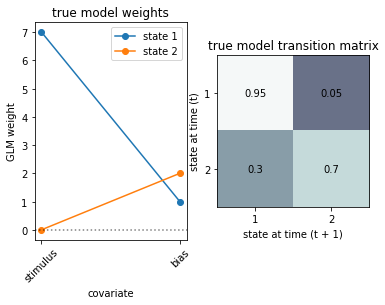

In [15]:
# plot generative parameters
plt.figure()

# plot state weights
plt.subplot(1,2,1)

for kk in range(nstates):
    plt.plot(wgen[kk,0], marker = 'o', lw = 1.5, label="state " + str(kk+1))

# axis options    
plt.title("true model weights")
plt.ylabel("GLM weight")
plt.xlabel("covariate")
plt.xticks([0, 1], ['stimulus', 'bias'], rotation = 45)
plt.axhline(y=0, color = "k", alpha = 0.5, ls = ":")
plt.legend()

# plot transition matrix
plt.subplot(1,2,2)
plt.imshow(A, vmin = -.8, vmax = 1, cmap = 'bone')

for ii in range(nstates):
    for jj in range(nstates):
        text = plt.text(jj, ii, str(A[ii, jj]), ha = 'center', va = 'center', color = 'k')      

#axis options    
plt.title("true model transition matrix")
plt.ylabel("state at time (t)")
plt.xlabel("state at time (t + 1)")
plt.xticks(range(nstates), ('1', '2'))
plt.yticks(range(nstates), ('1', '2'))

In [23]:
# defining relevant task variables
ntrials = 500
stimset = np.array([.6, 1.05, 1.38, 1.62, 1.95, 2.4])
zstimset = (stimset - np.mean(stimset))/np.std(stimset)
nstim = len(stimset)
boundary = np.mean(stimset)
stimsession = np.random.choice(stimset, ntrials)

xstart = 0
xstop = 3
dx = 1000
x = np.linspace(xstart, xstop, dx)
sigma = .2 # stim percept variance
biascoeff = .5

# randomly sampling stimuli for each session
np.random.seed(0)
nsessions = 50
inputs = np.ones((nsessions, ntrials, inputdim)) 
inputs[:,:,0] = np.random.choice(zstimset, (nsessions, ntrials)) 
inputs = list(inputs) #convert inptus to correct format

inputs[1].shape

(500, 2)

In [ ]:
# sample states and choices - Classic as mixture model
#Z, Y, C = [], [], []

# defining states
#for ss in range(nsessions):
#    Z.append(np.zeros(ntrials, dtype = int))
#    Z[ss][0] = int(np.random.choice(statespace, p = pi))
    
#    for tt in range(1, ntrials):
#        transvector = A[int(Z[ss][tt-1])]
#        Z[ss][tt] = int(np.random.choice(statespace, p = transvector))
        

# getting choices
#for ss in range(nsessions):
#    Y.append(np.zeros([ntrials, 1], dtype = int))
#    C.append(np.zeros([ntrials, 1], dtype = int))
    
#    for tt in range(ntrials):
#        getState = Z[ss][tt]
#        getX = inputs[ss][tt,0]
#        longflag = getStim > boundary
        
#        if getState == 0:
#            stimpercept = np.random.normal(getStim, sigma)
#            longchoice = stimpercept > boundary
#            correctchoice = (longflag & longchoice) | (~longflag & ~longchoice)
#            Y[ss][tt][0] = longchoice
#            C[ss][tt][0] = correctchoice
#        if getState == 1:
#            stimpercept = biascoeff + (np.random.choice((-1, 1)) * np.random.rand(1)/10)  
#            a = stimpercept 
#            longchoice = stimpercept > .5
#            correctchoice = (longflag & longchoice) | (~longflag & ~longchoice)
#            Y[ss][tt][0] = longchoice
#            C[ss][tt][0] = correctchoice

In [21]:
# sample states and choices - using GLM
Z, Y, C = [], [], []

# defining states
for ss in range(nsessions):
    Z.append(np.zeros(ntrials, dtype = int))
    Z[ss][0] = int(np.random.choice(statespace, p = pi))
    
    for tt in range(1, ntrials):
        transvector = A[int(Z[ss][tt-1])]
        Z[ss][tt] = int(np.random.choice(statespace, p = transvector))
        

# getting choices
for ss in range(nsessions):
    Y.append(np.zeros([ntrials, 1], dtype = int))
    C.append(np.zeros([ntrials, 1], dtype = int))
    
    for tt in range(ntrials):
        getState = Z[ss][tt]
        getX = inputs[ss][tt,:]
        longflag = getX[0] > 0
        getW = wgen[getState][0,:]
        plong = 1/(1 + np.exp(np.dot(getX, getW)))
        
        longchoice = np.random.choice([0, 1], p = [1 - plong, plong])
        correctchoice = (longflag & longchoice) | (~longflag & ~longchoice)
        Y[ss][tt][0] = longchoice
        C[ss][tt][0] = correctchoice    

In [17]:
# defining plong
plong = np.zeros([nsessions, nstim, nstates])   

for ss in range(nsessions):
    ss_stimset = inputs[ss][:,0]
    
    for st in range(nstim):
        stimflags = ss_stimset == zstimset[st] 
        
        for zz in range(nstates):
            stateflags = Z[ss] == zz
            flags = stimflags & stateflags
            longchoice = Y[ss][flags]
            
            if(sum(flags) == 0):
                plong[ss,st,zz] = 0
            else:
                plong[ss, st, zz] = sum(longchoice)/sum(flags)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


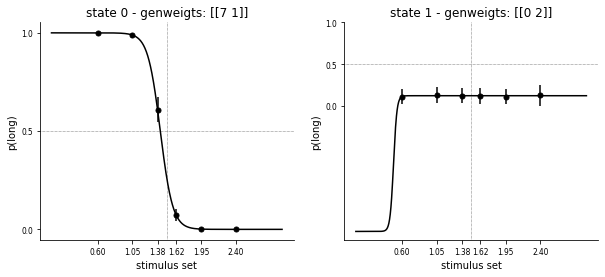

In [18]:
# plot psychometric curves 
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

xx = np.linspace(xstart, xstop, 1000)
for zz in range(nstates):
    stimmean = np.mean(plong[:,:,zz], axis = 0)
    stimstd = np.std(plong[:,:,zz], axis = 0)
    popt, _ = curve_fit(psycurves, stimset, stimmean)

    plt.subplot(1, 2, zz + 1)
    plt.errorbar(stimset, stimmean, stimstd, 
                 marker = 'o', linestyle = 'None',
                 markerfacecolor = 'k', markeredgecolor = 'k', 
                 ecolor = 'k', markersize = 5)
    plt.plot(xx, psycurves(xx, *popt), c = 'k')  
    
    plt.axvline(boundary, linestyle = ':', c = 'k',  lw = .5)
    plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)

    plt.xlabel('stimulus set')  
    plt.ylabel('p(long)')
    plt.title('state ' + str(zz) + ' - genweigts: ' +str(wgen[zz]))
    ax[zz].set_yticks([0, .5, 1])
    ax[zz].set_xticks(stimset)
    plt.xticks(fontsize = 7.5)
    plt.yticks(fontsize = 7.5)
    ax[zz].spines['top'].set_visible(False)
    ax[zz].spines['right'].set_visible(False)


KeyboardInterrupt: 

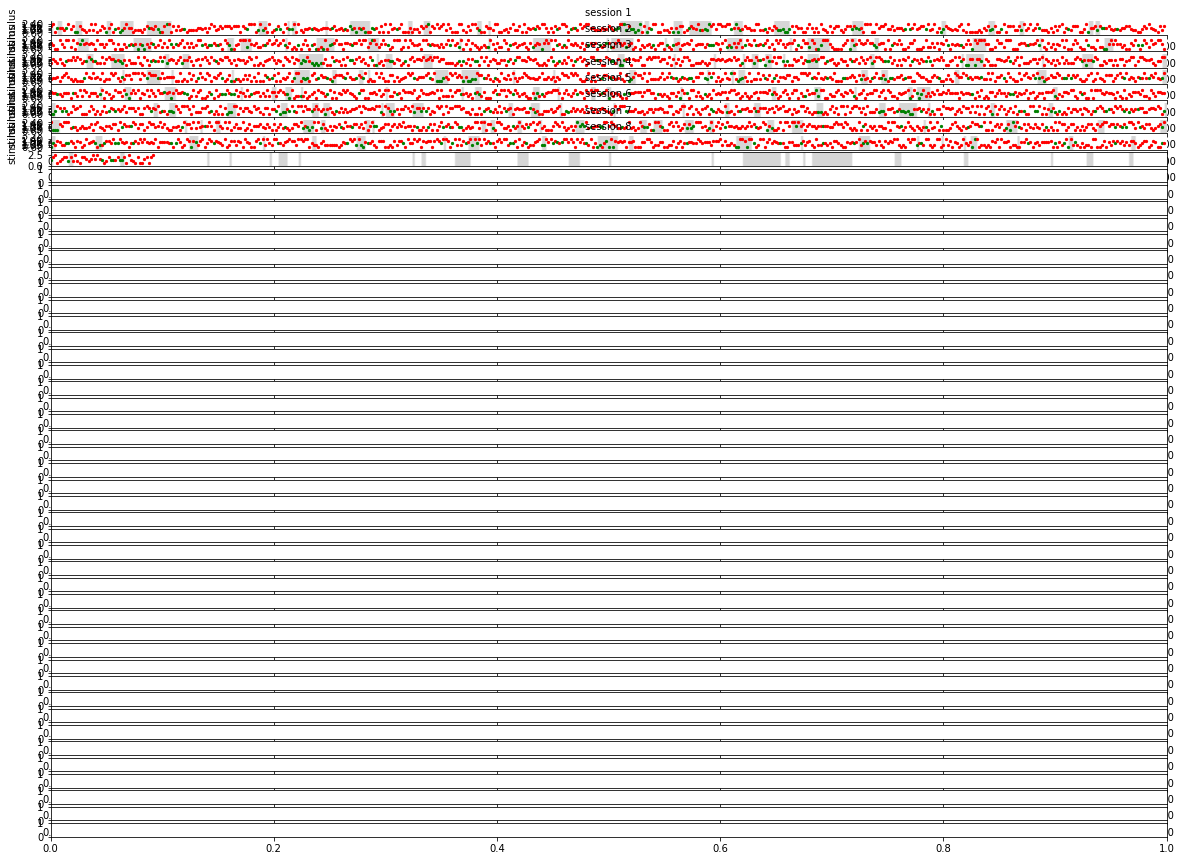

In [10]:
# plot state transition during the session
fig, ax = plt.subplots(nsessions, 1, figsize = (20, 15))

for ss in range(nsessions):
    plt.subplot(nsessions, 1, ss + 1)
    sess2plot = Z[ss]
    #ax[ss].step(range(ntrials), sess2plot, where = 'mid', c = 'k')
    plt.imshow(sess2plot[None, :],
           extent=[0,ntrials, 0, xstop],
           aspect = 'auto',
           cmap= 'binary',
           alpha = .8,
           vmin = 0,
           vmax = 5)
    
    for tt in range(ntrials):
        correct2plot = C[ss]
        stim2plot = inputs[ss][:,0]  
        if correct2plot[tt] == 1:
            ax[ss].scatter(tt, stimset[np.where(zstimset == stim2plot[tt])]  , c = 'green', s = 5)
        else:
            ax[ss].scatter(tt, stimset[np.where(zstimset == stim2plot[tt])], c = 'red', s = 5)
 
    # axis options
    plt.title('session ' + str(ss + 1), fontsize = 10)
    ax[ss].spines['top'].set_visible(False)
    ax[ss].spines['right'].set_visible(False)
    ax[ss].set_ylabel('stimulus')
    ax[ss].set_yticks(stimset)
plt.xlabel('trial number')
plt.axhline(boundary, linestyle = ':', c = 'k', lw = .5)

In [ ]:
true_latents, true_choices = [], []
for sess in range(nsessions):
    true_z, true_y = glmhmm.sample(ntrials, input=inputs[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [ ]:
# calculate true loglikelihood
fakedataLL = glmhmm.log_probability(Y, inputs = inputs) 
print("true ll = " + str(fakedataLL))

  0%|          | 0/50 [00:00<?, ?it/s]

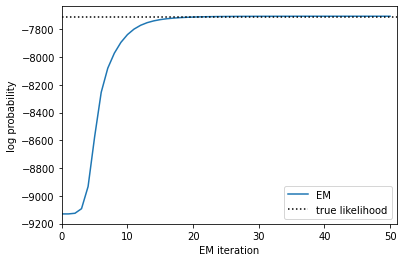

In [205]:
# creating model to fit generated data
newglmhmm = ssm.HMM(nstates, obsdim, inputdim, observations = 'input_driven_obs', 
                   observation_kwargs = dict(C = ncategories), transitions = "standard")
niterations = 50 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
glmhmm2fit = newglmhmm.fit(Y, inputs = inputs, method = 'em', num_iters = niterations, tolerance = 10**-5)

# plot LL convergence
fig = plt.figure()
plt.plot(glmhmm2fit, label = 'EM')
plt.plot([0, len(glmhmm2fit)], fakedataLL * np.ones(2), ':k', label = 'true likelihood')

# axis options
plt.legend(loc = 'lower right')
plt.xlabel('EM iteration')
plt.xlim(0, len(glmhmm2fit))
plt.ylabel('log probability')
plt.show()

In [27]:
ncategories


2

In [206]:
newglmhmm.permute(find_permutation(true_latents[0], newglmhmm.most_likely_states(true_choices[0], input = inputs[0])))

In [11]:
for st in range(nstim):
    plong = 1/(1+np.exp(-np.dot([stimset[st], 1], [wgen[0][0,0], 0])))
    plongnorm = 1/(1+np.exp(-np.dot([zstimset[st], 1], [wgen[0][0,0], 0])))
    print(plong, plongnorm)
    
print(newglmhmm.transitions.params[0][0,0])

0.9852259683067269 2.1061328652087767e-05
0.9993578202994141 0.004568345095071256
0.9999362195462742 0.19220588225115123
0.9999881123663553 0.8077941177488488
0.9999988200059715 0.9954316549049287
0.9999999494346891 0.999978938671348


NameError: name 'newglmhmm' is not defined

In [ ]:
# comparing learned and generative parameters
fig = plt.subplots(1,3)

plt.subplot(1,3,1)
for kk in range(nstates):
    plt.plot(range(inputdim), glmhmm.observations.params[kk][0], marker = 'o', linestyle='-',
             lw=1.5)
    plt.plot(range(inputdim), newglmhmm.observations.params[kk][0], linestyle = ':', marker = 'o',
             lw=1.5)

plt.ylabel("GLM weight")
plt.xticks([0, 1], ['stimulus', 'bias'], rotation=45)
plt.axhline(y = 0, color = "k", alpha = .5, ls = "--")

plt.subplot(1,3,2)

plt.imshow(A, vmin = -.8, vmax = 1, cmap = 'bone')

for ii in range(nstates):
    for jj in range(nstates):
        text = plt.text(jj, ii, str(np.around(A[ii, jj], decimals = 2)), ha="center", va="center", color = 'k')

plt.xlim(-0.5, nstates - 0.5)
plt.xticks(range(0, nstates), ('1', '2'))
plt.yticks(range(0, nstates), ('1', '2'))
plt.ylim(nstates - 0.5, -0.5)
plt.ylabel("state t")
plt.xlabel("state t + 1")
plt.title("true transitions")


plt.subplot(1, 3, 3)

plt.imshow(np.exp(newglmhmm.transitions.params[0]), vmin = -.8, vmax = 1, cmap = 'bone')

for ii in range(nstates):
    for jj in range(nstates):
        text = plt.text(jj, ii, str(np.around(np.exp(newglmhmm.transitions.params[0][ii, jj]), decimals=2)), 
                        ha="center", va="center", color = "k")
plt.xlim(-0.5, nstates - 0.5)
plt.xticks(range(0, nstates), ('1', '2'))
plt.yticks(range(0, nstates), ('1', '2'))
plt.ylim(nstates - 0.5, -0.5)
plt.title("learned transitions")
plt.subplots_adjust(0, 0, 1, 1)


Text(0, 0.5, 'p(state)')

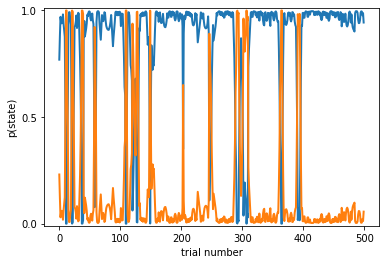

In [222]:
# get expected states
posterior_pstate = [newglmhmm.expected_states(data = data, input = inputs)[0]
                    for data, inputs
                    in zip(Y, inputs)]

plt.figure
sessionid = 0
for kk in range(nstates):
    plt.plot(posterior_pstate[sessionid][:, kk], label = 'state ' + str(kk + 1), lw = 2)

#plt.step(range(ntrials), Z[sessionid])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1])
plt.xlabel("trial number")
plt.ylabel("p(state)")